In [46]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Layer, Conv2D, UpSampling2D, ReLU, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.losses import Loss
import pdb

In [2]:
def swap_xy(boxes):
    xmin, ymin, xmax, ymax = tf.split(boxes, 4, axis=-1)
    nboxes = tf.concat([ymin, xmin, ymax, xmax], axis=-1)
    return nboxes

In [3]:
def convert_to_xywh(boxes):
    xy = (boxes[..., 2:] + boxes[..., :2]) * 0.5
    wh = boxes[..., 2:] - boxes[..., :2]
    nboxes = tf.concat([xy, wh], axis=-1)
    return nboxes

In [4]:
def convert_to_corners(boxes):
    xymin = boxes[..., :2] - boxes[..., 2:] * 0.5
    xymax = boxes[..., :2] + boxes[..., 2:] * 0.5
    nboxes = tf.concat([xymin, xymax], axis=-1)
    return nboxes

In [5]:
def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None,:2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8)
    return tf.clip_by_value(intersection_area, 0.0, 1.0)

In [6]:
def visualize_detections(image, boxes, classes, scores, figsize=(7, 7),
                         linewidth=1, color=[0, 0, 1]):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = '{}: {:.2f}'.format(_cls, score)
        x1, y1, x2, y2 = box
        w = x2 - x1
        h = y2 - y1
        patch = plt.Rectangle([x1, y1], w, h, fill=False, edgecolor=color,
                             linewidth=linewidth)
        ax.add_patch(patch)
        ax.text(x1, y1, text, bbox={'facecolor': color, 'alpha': 0.4},
                clip_box = ax.clipbox, clip_on=True)
    plt.show()
    return ax

In [7]:
class AnchorBox:
    def __init__(self, aspect_ratios=[0.5, 1.0, 2.0],
                 scales=[0, 1/3, 2/3],
                 areas=[32., 64., 128., 256., 512.],
                 levels=[3, 4, 5, 6, 7]):
        self.aspect_ratios = aspect_ratios
        self.scales = [2**x for x in scales]
        self.num_anchors = len(scales) * len(aspect_ratios)
        self.strides = [2**x for x in levels]
        self.areas = [x**2 for x in areas]
        self.anchor_dims = self.compute_anchor_dims()
        
    def compute_anchor_dims(self):
        anchor_dims_all = []
        for area in self.areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                h = tf.math.sqrt(area/ratio)
                w = area / h
                dims = tf.stack([w, h], axis=-1)
                dims = tf.reshape(dims, [1, 1, 2])
                for scale in self.scales:
                    anchor_dims.append(dims * scale)
            anchor_dims = tf.stack(anchor_dims, axis=2)
            anchor_dims_all.append(anchor_dims)
        return anchor_dims_all
    
    def get_anchors_by_level(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self.strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self.num_anchors, 1])
        dims = tf.tile(self.anchor_dims[level-3], 
                       [feature_height, feature_width, 1, 1])
#         pdb.set_trace()
        anchors = tf.concat([centers, dims], axis=-1)
        anchors = tf.reshape(anchors, [-1, 4])
        return anchors
        
    def get_anchors(self, image_height, image_width):
        anchors = [self.get_anchors_by_level(tf.math.ceil(image_height / stride),
                                             tf.math.ceil(image_width / stride), i + 3)
                   for i, stride in enumerate(self.strides)]
        anchors = tf.concat(anchors, axis=0)
        return anchors

In [8]:
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(shape=()) > 0.5:
        image = tf.image.flip_left_right(image)
        xmin, ymin, xmax, ymax = tf.split(boxes, 4, axis=-1)
        boxes = tf.concat([1-xmax, ymin, 1-xmin, ymax], axis=-1)
    return image, boxes

In [9]:
def resize_and_pad_image(image, min_side=800., max_side=1333.0,
                         jitter=[640, 1024], stride=128.):
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if jitter is not None:
        min_side = tf.random.uniform(shape=(), minval=jitter[0],
                                     maxval=jitter[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape *= ratio
    image = tf.image.resize(image, tf.cast(image_shape, tf.int32))
    padded_image_shape = tf.cast(tf.math.ceil(image_shape / stride) * stride,
                                 dtype=tf.int32)
    image = tf.image.pad_to_bounding_box(image, 0, 0, padded_image_shape[0], padded_image_shape[1])
    return image, image_shape, ratio

In [63]:
def preprocess_data(sample):
    image = sample['image']
    bbox = sample['objects']['bbox']
    class_id = tf.cast(sample['objects']['label'], dtype=tf.int32)
    
    bbox = swap_xy(bbox)
    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)
    xmin, ymin, xmax, ymax = tf.split(bbox, 4, axis=-1)
    xmin *= image_shape[1]
    xmax *= image_shape[1]
    ymin *= image_shape[0]
    ymax *= image_shape[0]
    
    bbox = tf.concat([xmin, ymin, xmax, ymax], axis=-1)
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

In [11]:
class LabelEncoder:
    def __init__(self, box_variance=[0.1, 0.1, 0.2, 0.2]):
        self.anchor_box = AnchorBox()
        self.box_variance = tf.convert_to_tensor(box_variance, dtype=tf.float32)
    def match_anchor_boxes(self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4):
#         pdb.set_trace()
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (matched_gt_idx, 
                tf.cast(positive_mask, dtype=tf.float32),
                tf.cast(ignore_mask, dtype=tf.float32))
    def compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat([
            (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
            tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:])
        ], axis=-1)
        box_target = box_target / self.box_variance
        return box_target
    def encode_sample(self, image_shape, gt_boxes, cls_ids):
#         pdb.set_trace()
        anchor_boxes = self.anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self.match_anchor_boxes(anchor_boxes, gt_boxes)
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self.compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids)
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label
    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]
        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self.encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()
        

In [12]:
def get_backbone():
    backbone = tf.keras.applications.ResNet50(include_top=False, input_shape=[None, None, 3])
    outputs = [backbone.get_layer(layer_name).output
               for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]]
    return tf.keras.models.Model(inputs=[backbone.input], outputs=outputs)

In [13]:
class FeaturePyramid(Layer):
    def __init__(self, backbone=None, **kwargs):
        super(FeaturePyramid, self).__init__(name='FeaturePyramid', **kwargs)
        self.backbone = backbone if backbone else get_backbone()
        self.conv_c3_1x1 = Conv2D(256, 1, 1, 'same')
        self.conv_c4_1x1 = Conv2D(256, 1, 1, 'same')
        self.conv_c5_1x1 = Conv2D(256, 1, 1, 'same')
        self.conv_c3_3x3 = Conv2D(256, 3, 1, 'same')
        self.conv_c4_3x3 = Conv2D(256, 3, 1, 'same')
        self.conv_c5_3x3 = Conv2D(256, 3, 1, 'same')
        self.conv_c6_3x3 = Conv2D(256, 3, 2, 'same')
        self.conv_c7_3x3 = Conv2D(256, 3, 2, 'same')
        self.upsample_2x = UpSampling2D(2)
        
    def call(self, image, training=False):
        c3, c4, c5 = self.backbone(image, training=training)
        p3 = self.conv_c3_1x1(c3)
        p4 = self.conv_c4_1x1(c4)
        p5 = self.conv_c5_1x1(c5)
        p4 = p4 + self.upsample_2x(p5)
        p3 = p3 + self.upsample_2x(p4)
        p3 = self.conv_c3_3x3(p3)
        p4 = self.conv_c4_3x3(p4)
        p5 = self.conv_c5_3x3(p5)
        p6 = self.conv_c6_3x3(c5)
        p7 = self.conv_c7_3x3(tf.nn.relu(p6))
        return p3, p4, p5, p6, p7

In [14]:
def build_head(output_filters, bias_init):
    head = Sequential([Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(Conv2D(256, 3, padding='same', 
                        kernel_initializer=kernel_init))
        head.add(ReLU())
    head.add(Conv2D(output_filters, 3, 1, padding='same', 
                    kernel_initializer=kernel_init,
                    bias_initializer=bias_init))
    return head

In [15]:
class RetinaNet(Model):
    def __init__(self, num_classes, backbone=None, **kwargs):
        super(RetinaNet, self).__init__(name='RetinaNet', **kwargs)
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes
        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")
    
    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(tf.reshape(self.cls_head(feature), [N, -1, self.num_classes]))
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)
        

In [16]:
class PredictionDecoder(Layer):
    def __init__(self, num_classes, confidence_threshold=0.05, 
                 nms_iou_threshold=0.5, max_detections_per_class=100,
                 max_detections=100, box_variance=[0.1, 0.1, 0.2, 0.2],
                 **kwargs):
        super(PredictionDecoder, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections
        self.anchor_box = AnchorBox()
        self.box_variance = tf.convert_to_tensor(box_variance, dtype=tf.float32)
    
    def decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self.box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:]
            ], axis=-1)
        return convert_to_corners(boxes)
    
    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self.anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self.decode_box_predictions(anchor_boxes[None, ...], box_predictions)
        
        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False)

### Loss function

In [68]:
class BoxLoss(Loss):
    def __init__(self, delta):
        super(BoxLoss, self).__init__(reduction='none', name='box_loss')
        self.delta = delta
        
    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        abs_difference = tf.abs(difference)
        squared_difference = tf.square(difference)
        loss = tf.where(tf.less(abs_difference, self.delta),
                        0.5 * squared_difference, 
                        abs_difference - 0.5)
        loss = tf.reduce_sum(loss, axis=-1)
        return loss

In [37]:
class FocalLoss(Loss):
    def __init__(self, alpha, gamma):
        super(FocalLoss, self).__init__(reduction='none', name='focal_loss')
        self.alpha = alpha
        self.gamma = gamma
    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(y_true, y_pred)
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self.alpha, 1.0 - self.alpha)
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self.gamma) * cross_entropy
        loss = tf.reduce_sum(loss, axis=-1)
        return loss

In [73]:
class RetinaLoss(Loss):
    def __init__(self, num_classes, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaLoss, self).__init__(reduction='auto', name='retina_net')
        self.focal_loss = FocalLoss(alpha, gamma)
        self.box_loss = BoxLoss(delta)
        self.num_classes = num_classes
        
    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(tf.cast(y_true[:, :, 4], dtype=tf.int32),
                                depth=self.num_classes, dtype=tf.float32)
        cls_preditions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        cls_loss = self.focal_loss(cls_labels, cls_preditions)
        box_loss = self.box_loss(box_labels, box_predictions)
        cls_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, cls_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        cls_loss = tf.math.divide_no_nan(tf.reduce_sum(cls_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = cls_loss + box_loss
        return loss

In [43]:
model_dir = "model/"
label_encoder = LabelEncoder()

num_classes = 80
batch_size = 2

learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)

In [74]:
resnet50_backbone = get_backbone()
loss_fn = RetinaLoss(num_classes=80)
model = RetinaNet(num_classes=80, backbone=resnet50_backbone)

optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)


In [75]:
model.compile(loss=loss_fn, optimizer=optimizer)

In [47]:
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    )
]

In [61]:
(train_dataset, val_dataset), dataset_info = tfds.load(
    "coco/2017", split=["train", "validation"], with_info=True, data_dir="data"
)

In [64]:
autotune = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.apply(tf.data.experimental.ignore_errors())
val_dataset = val_dataset.prefetch(autotune)

In [67]:
for x in train_dataset.take(1):
    print(x[0].shape, x[1].shape)

(2, 768, 1024, 3) (2, 147312, 5)


In [76]:
# Uncomment the following lines, when training on full dataset
# train_steps_per_epoch = dataset_info.splits["train"].num_examples // batch_size
# val_steps_per_epoch = \
#     dataset_info.splits["validation"].num_examples // batch_size

# train_steps = 4 * 100000
# epochs = train_steps // train_steps_per_epoch

epochs = 1

# Running 100 training and 50 validation steps,
# remove `.take` when training on the full dataset

model.fit(
    train_dataset.take(100),
    validation_data=val_dataset.take(50),
    epochs=epochs,
    callbacks=callbacks_list,
    verbose=1,
)

 88/100 [=========================>....] - ETA: 3:47 - loss: 71.1269

KeyboardInterrupt: 

In [22]:
# prepare inference model
image = Input(shape=[None, None, 3], name='image')
predictions = model(image, training=False)

In [23]:
predictions.shape

TensorShape([None, None, 84])

In [25]:
detections = PredictionDecoder(80, confidence_threshold=0.5)(image, predictions)

In [26]:
inference_model = Model(inputs=image, outputs=detections)

In [35]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, jitter=None)
#     ratio = 1.0
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

In [32]:
(train_dataset, val_dataset), dataset_info = tfds.load("coco/2017", 
                                                       split=["train", "validation"], 
                                                       with_info=True, 
                                                       data_dir="data")
int2str = dataset_info.features["objects"]["label"].int2str

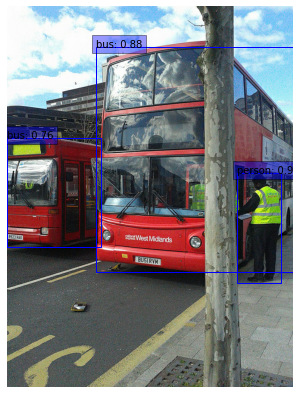

In [36]:
for sample in val_dataset.take(1):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )